In [198]:
#import geopy
from geopy import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import great_circle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [199]:
raw_data = pd.read_csv('merge_data_update.csv', index_col=0)

In [200]:
# Analysis of what rows should be dropped is in 
# the second half of the Correlation_Multicollinearity_Investigation.ipynb notebook.

Drop List:
- MSSubClasses 90 and 190.(multi-family properties)
- New Home sales and Court Officer Deed sales (shown to have different characteristics from others).
- Abnormal Sale Condition (foreclosures, etc), they dont fit the distribution, as seen by t-test. 
- Max GrLivArea = 3000sqft. Upper boxplot whisker for home size at 2,654sqft, still some values up to 3,000sqft, and close enough to the common data values to likey not have significant errors
- MSZoning drop C, I, A (focused on residential properties)
- LotArea, cutoff at 43,560 (1 acre. Very large for Ames, Iowa).
- Utilities, drop NoSewr. Not enough homes with septic tanks in the dataset (only 2) to model the hit to home value from not being connected to public sewers.
- OverallQual - Drop 1 and 2. We are not interested in pricing homes of extremely substandard quality. 

In [201]:
# Drop Column Formulation

# Multi-fam drops
MS90 = raw_data['MSSubClass']==90
MS190 = raw_data['MSSubClass']==190
MSSubClass_drops = np.logical_or(MS90, MS190)
print('MS Subclass Drops: ', np.sum(MSSubClass_drops))

# SaleType Drops
new_sales = raw_data['SaleType']=='New'
COD_sales = raw_data['SaleType']=='COD'
SaleType_drops = np.logical_or(new_sales, COD_sales)
tot1_drops = np.logical_or(MSSubClass_drops, SaleType_drops)
print('SaleType Subclass Drops: ', np.sum(tot1_drops)-np.sum(MSSubClass_drops))

# Abnormal Condition drops
abnormal_drops = raw_data['SaleCondition']=='Abnorml'
tot2_drops = np.logical_or(abnormal_drops, tot1_drops)
print('Abnormal Sale Condition drops: ', np.sum(tot2_drops) - np.sum(tot1_drops))

# Square Footage Cutoff
lg_sqft = raw_data['GrLivArea']>3000
tot3_drops = np.logical_or(tot2_drops, lg_sqft)
print('Large SqFt drops: ', np.sum(tot3_drops) - np.sum(tot2_drops))

# Zoning C, I, A drops
zoning_drops = np.logical_or(np.logical_or(raw_data['MSZoning']=='C (all)', raw_data['MSZoning']=='I (all)'), 
                            raw_data['MSZoning']=='A (agr)')
tot4_drops = np.logical_or(zoning_drops, tot3_drops)
print('MSZoning drops: ', np.sum(tot4_drops) - np.sum(tot3_drops))

#LotArea cutoff 
lots_cutoff = raw_data['LotArea']>43560
tot5_drops = np.logical_or(lots_cutoff, tot4_drops)
print('LotArea cutoff drops: ', np.sum(tot5_drops) - np.sum(tot4_drops))

#Utilities NoSewr drop
no_sewer = raw_data['Utilities']=='NoSewr'
tot6_drops = np.logical_or(no_sewer, tot5_drops)
print('No Sewer drops: ', np.sum(tot6_drops) - np.sum(tot5_drops))

# OverallQual drops
oq_drops = raw_data['OverallQual']<3
final_drops = np.logical_or(oq_drops, tot6_drops)
print('OverallQual drops: ', np.sum(final_drops) - np.sum(tot6_drops))

# Total Drop Number
print('\nTotal number of rows dropped: ', np.sum(final_drops))

MS Subclass Drops:  140
SaleType Subclass Drops:  125
Abnormal Sale Condition drops:  44
Large SqFt drops:  16
MSZoning drops:  13
LotArea cutoff drops:  11
No Sewer drops:  1
OverallQual drops:  11

Total number of rows dropped:  361


In [202]:
tdata = raw_data[~final_drops]
print('Rows in filtered data: ', tdata.shape[0])


Rows in filtered data:  2219


In [203]:
tdata

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ClassPr_S,ClassSc_S,SchD_S,TxD_S,LndAc_S,ImpAc_S,OthAc_S,HSTtl_D,HSTtl_S,GLA
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,RESIDENTIAL,1-STORY 1945 & OLDER,1.0,1.0,37300.0,0.0,111700.0,NaN,NaN,856.0
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,RESIDENTIAL,1-STORY TWNHM - 1946 & NEWER,1.0,1.0,43500.0,0.0,130600.0,NaN,NaN,1049.0
3,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,...,RESIDENTIAL,2-STORY 1945 & OLDER,1.0,1.0,31100.0,0.0,93300.0,NaN,4850.0,1039.0
4,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,...,RESIDENTIAL,2-STORY 1946 & NEWER,1.0,1.0,64300.0,0.0,192800.0,NaN,NaN,1665.0
5,908128060,1922,198500,85,RL,64.0,7301,Pave,NaN,Reg,...,RESIDENTIAL,SPLIT FOYER,1.0,1.0,53700.0,0.0,161100.0,NaN,NaN,1922.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2574,908128100,1724,196500,60,RL,62.0,7162,Pave,NaN,Reg,...,RESIDENTIAL,2-STORY 1946 & NEWER,1.0,1.0,54700.0,0.0,163900.0,4850.0,4850.0,1725.0
2575,903205040,952,121000,30,RL,NaN,8854,Pave,NaN,Reg,...,RESIDENTIAL,1-STORY 1945 & OLDER,1.0,1.0,34600.0,0.0,103900.0,4850.0,4850.0,952.0
2576,905402060,1733,139600,20,RL,NaN,13680,Pave,NaN,IR1,...,RESIDENTIAL,1-STORY 1946 & NEWER ALL STYLES,1.0,1.0,46300.0,0.0,138800.0,NaN,NaN,1733.0
2578,907192040,1842,217500,60,RL,NaN,8826,Pave,NaN,Reg,...,RESIDENTIAL,2-STORY 1946 & NEWER,1.0,1.0,66300.0,0.0,198900.0,4850.0,4850.0,1842.0


In [204]:
tdata.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond

## Drop Columns

In [205]:
# These columns will be dropped later by Gabby: 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'

drop_list = ['Street', 'Alley', 'Utilities', 'LandSlope','Condition2', 'MapRefNo', 'ZngCdPr', 'ZngOLPr', 'ZngOLSc', 
           'ClassSc_S', 'Heating', 'LowQualFinSF', 'KitchenAbvGr', 'RoofMatl', 'ExterCond', 'BsmtFinSF1', 
           'BsmtFinSF2', 'BsmtFinType2', 'GarageQual', 'GarageCond', 'PoolArea', 'PoolQC', 'MiscFeature', 'MiscVal', 'YrSold', 'SaleType', 'SaleCondition', 
             'HSTtl_D', 'HSTtl_S', 'GLA', 'MSZoning', 'HouseStyle', 'ClassPr_S', 'ImpAc_S', 'Exterior2nd', 'GarageYrBlt',
            'LotFrontage']

In [206]:
tdata = tdata.drop(drop_list, axis=1)

In [207]:
tdata.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'Exterior1st', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars',
       'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'Fence', 'MoSold',
       'GeoRefNo', 'Prop_Addr', 'SchD_S', 'TxD_S', 'LndAc_S', 'OthAc_S'],
      dtype='object')

# ====================
# RYAN'S CODE SECTION
# ====================

## For 'HeatingQC', combine the one 'Po' with 'Fa' and Dummify

In [208]:
# Check initial state
tdata['HeatingQC'].value_counts()

Ex    1142
TA     624
Gd     389
Fa      63
Po       1
Name: HeatingQC, dtype: int64

In [209]:
# Replace the one 'Po' with 'Fa'
tdata['HeatingQC'].replace('Po', 'Fa', inplace=True)

In [210]:
# Check transformation

tdata['HeatingQC'].value_counts()

Ex    1142
TA     624
Gd     389
Fa      64
Name: HeatingQC, dtype: int64

In [211]:
tdata['HeatingQC'] = tdata['HeatingQC'].astype('category')

In [212]:
print(tdata['HeatingQC'].dtypes)

category


## 'CentralAir': Making 'Y' == 0, and 'N' == 1, rename NoCentralAir

Changing the base case (yes) to be included in the intercept value.

In [213]:
# Initial State
tdata['CentralAir'].value_counts()

Y    2126
N      93
Name: CentralAir, dtype: int64

In [214]:
# Transforming the column, Y == 0 and N == 1
tdata['CentralAir'].replace('Y', 0, inplace=True)
tdata['CentralAir'].replace('N', 1, inplace=True)
tdata.rename(columns={'CentralAir':'NoCentralAir'}, inplace=True)

In [215]:
# Checking the transformation
tdata['NoCentralAir'].value_counts()

0    2126
1      93
Name: NoCentralAir, dtype: int64

## 'Electrical' - Fill NaN, Dummify

If initial thought is correct, age of house should determine the electrical system. So YrBuilt for the missing value will tell us with high probability the electrical in the house.

In [216]:
# Find info on Year Built for each 'Electrical' class
tdata.groupby('Electrical')['YearBuilt'].agg(['mean', 'std'])

,mean,std
Electrical,,
FuseA,1938.962687,17.787132
FuseF,1932.760000,15.100441
FuseP,1927.000000,2.828427
SBrkr,1973.689840,28.232981


In [217]:
# Get the year for the missing value
tdata[tdata['Electrical'].isnull()].YearBuilt

2442    2006
Name: YearBuilt, dtype: int64

The YearBuilt for the observation with missing 'Electrical' is 2006, a clear sign that the value should be filled in with 'SBrkr'

In [218]:
# Initial State
print(tdata['Electrical'].value_counts())
print('Missing Values: ', np.sum(tdata['Electrical'].isnull()))

SBrkr    2057
FuseA     134
FuseF      25
FuseP       2
Name: Electrical, dtype: int64
Missing Values:  1


In [219]:
# Filling the in missing value with 'SBrkr'
tdata['Electrical'].fillna(value='SBrkr', inplace=True)

In [220]:
# Creating Binary NonStdElectrical Y/N for this.
tdata['Electrical'].replace('SBrkr', 0, inplace=True)
tdata['Electrical'].replace(['FuseA', 'FuseF', 'FuseP'], 1, inplace=True)
# Rename Column
tdata.rename(columns={'Electrical': 'NonStdElectrical'}, inplace=True)

In [221]:
# Checking the transformation
print(tdata['NonStdElectrical'].value_counts())
print('Missing Values: ', np.sum(tdata['NonStdElectrical'].isnull()))

0    2058
1     161
Name: NonStdElectrical, dtype: int64
Missing Values:  0


## 'BsmtFullBath' - Fill Nan's

There are two missing values, check if those observations have basements.

In [222]:
tdata[tdata['BsmtFullBath'].isnull()].iloc[:,20:30]

,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtUnfSF,TotalBsmtSF,HeatingQC,NoCentralAir,NonStdElectrical


Confirmed that one has no information at all for any basement column, and one has 0 for TotalBsmtSF, so I am comfortable saying those missing values are because the houses in the observations don't have basements. Will set them to 0.

In [223]:
# Initial State
tdata['BsmtFullBath'].value_counts()

0.0    1271
1.0     938
2.0      10
Name: BsmtFullBath, dtype: int64

In [224]:
# Filling in missing values with 0
tdata['BsmtFullBath'].fillna(value=0, inplace=True)

In [225]:
# Checking the transformation
print(tdata['BsmtFullBath'].value_counts())
print('Missing values: ', np.sum(tdata['BsmtFullBath'].isnull()))

0.0    1271
1.0     938
2.0      10
Name: BsmtFullBath, dtype: int64
Missing values:  0


## BsmtHalfBath - Fill NaN's

Should be the same as BsmtFullBath work. There are two missing values, check if those observations have basements.

In [226]:
tdata[tdata['BsmtHalfBath'].isnull()].iloc[:,20:30]

,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtUnfSF,TotalBsmtSF,HeatingQC,NoCentralAir,NonStdElectrical


It's the same rows of data as the above BsmtFullBath Nan's so treat them the same way. Fill with Zeros.

In [227]:
# Initial State
print(tdata['BsmtHalfBath'].value_counts())
print('Missing values: ', np.sum(tdata['BsmtHalfBath'].isnull()))

0.0    2073
1.0     145
2.0       1
Name: BsmtHalfBath, dtype: int64
Missing values:  0


In [228]:
# Filling in missing values with 0
tdata['BsmtHalfBath'].fillna(value=0, inplace=True)

In [229]:
# Checking the transformation
print(tdata['BsmtHalfBath'].value_counts())
print('Missing values: ', np.sum(tdata['BsmtHalfBath'].isnull()))

0.0    2073
1.0     145
2.0       1
Name: BsmtHalfBath, dtype: int64
Missing values:  0


## 'KitchenQual' - Combine the one 'Po' into 'Fa', Dummify

In [230]:
# Initial State
tdata['KitchenQual'].value_counts()

TA    1139
Gd     923
Ex     110
Fa      47
Name: KitchenQual, dtype: int64

In [231]:
# Replace the one 'Po' with 'Fa'
tdata['KitchenQual'].replace('Po', 'Fa', inplace=True)

In [232]:
# Check transformation
tdata['KitchenQual'].value_counts()

TA    1139
Gd     923
Ex     110
Fa      47
Name: KitchenQual, dtype: int64

In [233]:
tdata['KitchenQual'] = tdata['KitchenQual'].astype('category')
print(tdata['KitchenQual'].dtypes)

category


## 'YearRemodAdd' - Binarize for Y/N Remodeled, and create 'RemodelYrsAftBuilt'

In [234]:
# Remodeled houses had YearRemodAdd date AFTER YearBuilt.
# If the years are the same it means the house was not remodeled.
## Making a binary column. Later will have to see if it is useful.##
tdata['Remodeled'] = tdata['YearRemodAdd'] > tdata['YearBuilt']

In [235]:
# Diagnstic
# What percent of houses have been remodeled?
np.mean(tdata['Remodeled'])

0.4583145561063542

<AxesSubplot:title={'center':'SalePrice'}, xlabel='Remodeled'>

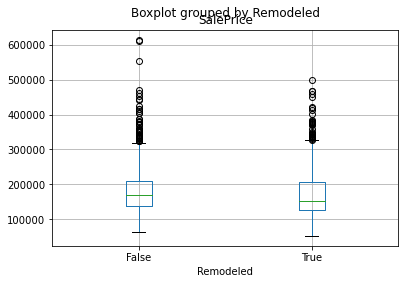

In [236]:
# Diagnostic
#Visualize the price differences
tdata.boxplot(column='SalePrice', by='Remodeled')

In [237]:
# Diagnostic
#Describing the remodel years for homes that have been remodeled.
tdata[tdata['Remodeled']==True].YearRemodAdd.describe()

count    1017.000000
mean     1986.910521
std        21.692438
min      1950.000000
25%      1972.000000
50%      1996.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

(0.0, 60.0)

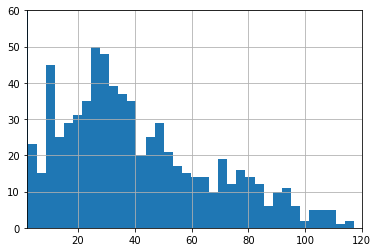

In [238]:
#Visualize what the column will be 
(tdata['YearRemodAdd'] - tdata['YearBuilt']).hist(bins=40)
plt.xlim(2,120)
plt.ylim(0, 60)

In [239]:
# Create Column 'RemodelYrsAftBuilt'
tdata['RemodelYrsAftBuilt'] = tdata['YearRemodAdd'] - tdata['YearBuilt']
tdata['RemodelYrsAftBuilt'].value_counts()
      

 0      1201
 1       293
 30       25
 25       22
 40       20
        ... 
 107       1
 109       1
 115       1
 121       1
-1         1
Name: RemodelYrsAftBuilt, Length: 113, dtype: int64

In [240]:
# See the new columns, show they look good.
tdata.iloc[:,-2:]

,Remodeled,RemodelYrsAftBuilt
0,True,11
1,False,0
3,True,103
4,False,0
5,False,0
...,...,...
2574,True,1
2575,True,34
2576,False,0
2578,False,0


In [241]:
# Removing original YearRemodAdd Column
tdata.drop('YearRemodAdd', axis=1, inplace=True)

 ## Functional - 3 Categories: Typ, Min, Maj(w/ mod, sal). Dummify

In [242]:
# Initial State
tdata['Functional'].value_counts()

Typ     2073
Min2      57
Min1      50
Mod       21
Maj1      12
Maj2       6
Name: Functional, dtype: int64

In [243]:
# Combine the Min1, Min2 into a Min category. Combine the Maj1, Maj2, Mod, and Sal into a Maj category
tdata['Functional'].replace(['Min1', 'Min2'], 'Min', inplace=True)
tdata['Functional'].replace(['Maj1', 'Maj2', 'Mod', 'Sal'], 'Maj', inplace=True)

In [244]:
# Check the result
tdata['Functional'].value_counts()

Typ    2073
Min     107
Maj      39
Name: Functional, dtype: int64

## RoofStyle - Combine into Hip, Gabel, Other. Then Dummify.

In [245]:
# Initial State
tdata['RoofStyle'].value_counts()

Gable      1784
Hip         395
Gambrel      17
Flat         11
Mansard       9
Shed          3
Name: RoofStyle, dtype: int64

In [246]:
# Combine Gambrel, Flat, Mansard, and Shed into 'Other'
tdata['RoofStyle'].replace(['Gambrel', 'Flat', 'Mansard', 'Shed'], 'Other', inplace=True)

In [247]:
# Check the Transformation
tdata['RoofStyle'].value_counts()

Gable    1784
Hip       395
Other      40
Name: RoofStyle, dtype: int64

In [248]:
tdata['RoofStyle'] = tdata['RoofStyle'].astype('category')
print(tdata['RoofStyle'].dtypes)

category


## Exterior1st - Combine Categories into similar materials, then dummify.

Materials to combine:
Value, roughly, high to low.

No stone houses. 

Common brick is a significant upgrade, can't be combined. Not even sure what to combine it with based on value, its definitely the leader.

Vinyl Siding

Plywood - Better than hardboard, so should be its own category.

Wood shingles - its own category.

Stucco - Possibly similar enough to Cement Board (value-wise) to be combined with it.
Cement Board - Put w/ Wood siding, similar traits/value/looks, different materials.

Metal Siding - definitely its own category.

Cinderblock - Other, not used in a while (inferior to concrete)
Precast - Other (not different enough from other 'Other's to be significant)
Asphalt Shingles - Other (not different enough from other 'Other's to be significant)
Immitation Stucco - Other.

Hardboard - it's own category, cheapo finish.

Asbestos shingles means old, not used in last 50 years. (banned in the 70's) Maybe drop.

In [249]:
# Inital State
tdata['Exterior1st'].value_counts()

VinylSd    763
HdBoard    375
MetalSd    343
Wd Sdng    325
Plywood    156
CemntBd     83
BrkFace     67
WdShing     44
Stucco      32
AsbShng     23
BrkComm      5
PreCast      1
CBlock       1
ImStucc      1
Name: Exterior1st, dtype: int64

In [250]:
# Combine Stucco, Cement Board, and Wood siding (based on value). New cat called Stc_CemBd_WdSd
tdata['Exterior1st'].replace(['Stucco', 'CemntBd', 'Wd Sdng'], 'Stc_CemBd_WdSd', inplace=True)
# Combine Cinderblock, Precast, Asphalt Singles, Imitation Stucco into other.
tdata['Exterior1st'].replace(['CBlock', 'PreCast', 'AsphShn', 'ImStucc'], 'Other', inplace=True)

# Potentially drop asbestos shingles, no longer used (actually banned) and might be captured in age of house. 
# Or, conversely, might be a significant negative.

In [251]:
# Check the combinations
tdata['Exterior1st'].value_counts()

VinylSd           763
Stc_CemBd_WdSd    440
HdBoard           375
MetalSd           343
Plywood           156
BrkFace            67
WdShing            44
AsbShng            23
BrkComm             5
Other               3
Name: Exterior1st, dtype: int64

Still an aweful lot of categories. Maybe combine BrkComm with VinylSd and Plywood. (even though it is more valuable), and maybe combine Other with HdBoard (both low-value cats, even if different). Maybe combine wood shingles withCemBd_WdSd. Talk to team.

VinylSd, BrkComm, Plywood
HdBoard, Other
WdShing, Stc_CemBd_WdSd (Stucco, Cement Board, Wood Siding)

In [252]:
# Combine Wood shingles into Stc_CemBd_WdSd
tdata['Exterior1st'].replace(['Stc_CemBd_WdSd', 'WdShing'], 'Stc_CemBd_WdSdSh', inplace=True)
# Combine BrkComm with VinylSd, Plywood. 
tdata['Exterior1st'].replace(['BrkComm', 'VinylSd', 'Plywood'], 'VinylPlywBrkcom', inplace=True)
# Combine HdBoard and Other
tdata['Exterior1st'].replace(['Other', 'HdBoard'], 'HdbdOther', inplace=True)

In [253]:
tdata['Exterior1st'].value_counts()

VinylPlywBrkcom     924
Stc_CemBd_WdSdSh    484
HdbdOther           378
MetalSd             343
BrkFace              67
AsbShng              23
Name: Exterior1st, dtype: int64

In [254]:
tdata['Exterior1st'] = tdata['Exterior1st'].astype('category')
print(tdata['Exterior1st'].dtypes)

category


## MasVnrType - Combine Bricks, Investigate Nulls, Dummify

In [255]:
# Initial state
print(tdata['MasVnrType'].value_counts())
print('Mising values: ', np.sum(tdata['MasVnrType'].isnull()))

None       1334
BrkFace     711
Stone       149
BrkCmn       14
Name: MasVnrType, dtype: int64
Mising values:  11


In [256]:
tdata[tdata['MasVnrType'].isnull()] # Changed the column indees to investigate

,PID,GrLivArea,SalePrice,MSSubClass,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,Fence,MoSold,GeoRefNo,Prop_Addr,SchD_S,TxD_S,LndAc_S,OthAc_S,Remodeled,RemodelYrsAftBuilt
175,528439010,1460,247000,20,10037,Reg,Lvl,Corner,Somerst,Feedr,...,NaN,8,528439010.0,2625 YORKSHIRE ST,1.0,1.0,70300.0,210700.0,True,1
787,528240070,1960,216500,60,7851,Reg,Lvl,Inside,Gilbert,Norm,...,NaN,5,528240070.0,3907 WESTLAWN DR,5.0,45.0,64600.0,193700.0,False,0
871,907260030,1725,198500,60,8749,Reg,Lvl,Inside,CollgCr,Norm,...,NaN,11,907260030.0,5014 CLEMENS BLVD,1.0,1.0,62100.0,186200.0,False,0
891,528290090,1414,176000,60,7750,Reg,Lvl,Inside,Gilbert,RRAn,...,NaN,4,528290090.0,3813 WELBECK DR,5.0,45.0,48400.0,145000.0,False,0
1041,531371050,1200,184900,20,10083,Reg,Lvl,Inside,SawyerW,Norm,...,NaN,8,531371050.0,5429 TENNESSEE ST,1.0,1.0,54800.0,164400.0,False,0
1161,534104100,1812,205000,60,7500,Reg,Lvl,Inside,Somerst,Norm,...,NaN,4,534104100.0,2650 SOMERSET DR,1.0,1.0,63100.0,189300.0,False,0
1355,528480160,1665,205950,60,8125,Reg,Lvl,Inside,Somerst,Norm,...,NaN,5,528480160.0,2615 CLAYTON DR,1.0,1.0,67300.0,201900.0,False,0
1553,907251090,2031,237000,60,9473,Reg,Lvl,Inside,CollgCr,Norm,...,NaN,3,907251090.0,522 SMILEY AVE,1.0,1.0,76100.0,228300.0,False,0
2033,908130020,914,117250,20,8050,Reg,Lvl,Inside,Edwards,Norm,...,NaN,4,908130020.0,206 DOTSON DR,1.0,1.0,40400.0,121200.0,False,0
2477,528250010,1394,165500,80,11950,IR1,Lvl,Corner,Gilbert,Norm,...,NaN,10,528250010.0,4015 HYDE AVE,5.0,45.0,51900.0,155800.0,False,0


From inspection, these null-values are in rows that:
1) Are of all different zoning types.
2) 1/3 have missing lot frontage
3) Most are 1Fam building types
4) Built in 2000 or later.
5) NaN for MasVnrArea
6) Foundations are all PConc
7) Most have paved drives and garages
8) All have NaN for Fence

Don't see any special relatinoships, and none have MasVnrArea, so going to fill these NaN's in as None (the mode)

In [257]:
# Filling in missing values with 'None'
tdata['MasVnrType'].fillna(value='None', inplace=True)

In [258]:
# Checking the transformation
print(tdata['MasVnrType'].value_counts())
print('Missing values: ', np.sum(tdata['MasVnrType'].isnull()))

None       1345
BrkFace     711
Stone       149
BrkCmn       14
Name: MasVnrType, dtype: int64
Missing values:  0


In [259]:
# Combining Stone and BrkCmn, those are both much higher value than BrkFace.
tdata['MasVnrType'].replace(['Stone', 'BrkCmn'], 'StoneBrkcom', inplace=True)

In [260]:
# Checking the transformation
tdata['MasVnrType'].value_counts()

None           1345
BrkFace         711
StoneBrkcom     163
Name: MasVnrType, dtype: int64

In [261]:
tdata['MasVnrType'] = tdata['MasVnrType'].astype('category')
print(tdata['MasVnrType'].dtypes)

category


## MasVnrArea - Fill NaN's

Already found out that the NaN's in this column are the same as the ones in the MasVnrType column above. I filled those in with None for type so am filling these in with 0 for Area.

In [262]:
# Initial State
print(tdata['MasVnrArea'].value_counts())
print('Missing Values: ', np.sum(tdata['MasVnrArea'].isnull()))
#Numerical variable, with a large amount of Zeros.

0.0       1329
120.0       12
216.0       11
108.0        9
176.0        9
          ... 
616.0        1
632.0        1
396.0        1
406.0        1
1159.0       1
Name: MasVnrArea, Length: 385, dtype: int64
Missing Values:  11


In [263]:
# Now filling the NaN's with zeros
tdata['MasVnrArea'].fillna(value=0, inplace=True)

In [264]:
# Check that our fills went correctly
print(tdata['MasVnrArea'].value_counts())
print('Missing Values: ', np.sum(tdata['MasVnrArea'].isnull()))

0.0       1340
120.0       12
216.0       11
108.0        9
176.0        9
          ... 
616.0        1
632.0        1
396.0        1
406.0        1
1159.0       1
Name: MasVnrArea, Length: 385, dtype: int64
Missing Values:  0


## Foundation - Dummify
Maybe condense later. Potentially ask Mr. Burakowski

In [265]:
tdata['Foundation'].value_counts()

PConc     978
CBlock    976
BrkTil    230
Slab       24
Stone       6
Wood        5
Name: Foundation, dtype: int64

In [266]:
tdata['Foundation'] = tdata['Foundation'].astype('category')
print(tdata['Foundation'].dtypes)

category


## BsmtQual - No Basement cat from NaN's, Combine 'Po' into 'Fa', Dummify

In [267]:
# Initial State
print(tdata['BsmtQual'].value_counts())
print('Missing values: ', np.sum(tdata['BsmtQual'].isnull()))

TA    1000
Gd     972
Ex     145
Fa      62
Name: BsmtQual, dtype: int64
Missing values:  40


In [268]:
# Combine 'Po' into 'Fa'
tdata['BsmtQual'].replace('Po', 'Fa', inplace=True)
# Make 'None' category for NaN's
tdata['BsmtQual'].fillna(value='None', inplace=True)

In [269]:
# Check Transformation
print(tdata['BsmtQual'].value_counts())
print('Missing values: ', np.sum(tdata['BsmtQual'].isnull()))

TA      1000
Gd       972
Ex       145
Fa        62
None      40
Name: BsmtQual, dtype: int64
Missing values:  0


In [270]:
tdata['BsmtQual'] = tdata['BsmtQual'].astype('category')
print(tdata['BsmtQual'].dtypes)

category


## BsmtCond - Combine 'Po' into 'Fa', 'Ex' into 'Gd'. Fill NaN's w/ 'None', the Dummify

In [271]:
# Initial State
print(tdata['BsmtCond'].value_counts())
print('Missing values: ', np.sum(tdata['BsmtCond'].isnull()))

TA    2023
Gd      85
Fa      67
Ex       3
Po       1
Name: BsmtCond, dtype: int64
Missing values:  40


In [272]:
# Combine 'Po' into 'Fa', and 'Ex' into 'Gd'
tdata['BsmtCond'].replace('Po', 'Fa', inplace=True)
tdata['BsmtCond'].replace('Ex', 'Gd', inplace=True)
# Fill NaN's with 'None'
tdata['BsmtCond'].fillna(value='None', inplace=True)

In [273]:
# Checking the transformation
tdata['BsmtCond'].value_counts()

TA      2023
Gd        88
Fa        68
None      40
Name: BsmtCond, dtype: int64

In [274]:
tdata['BsmtCond'] = tdata['BsmtCond'].astype('category')
print(tdata['BsmtCond'].dtypes)

category


## BsmtExposure - Create a binary y/n. 'Gd', 'Av' == 1, rest == 0

Need to figure out what the two NaN's are that are not similar to the rest of the basement column NaN's and decide what to do with them.

In [275]:
expose_df = tdata[tdata['BsmtExposure'].isnull()]
cond_df = raw_data[raw_data['BsmtCond'].isnull()]
#The rows not shared w/ other Bsmt Columns
expose_df[~expose_df.index.isin(cond_df.index)].iloc[:, 20:30] #changed the last columns indexes to visually inspect

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtUnfSF,TotalBsmtSF,HeatingQC,NoCentralAir,NonStdElectrical,1stFlrSF
813,Gd,TA,NaN,Unf,936.0,936.0,Ex,0,0,936
1201,Gd,TA,NaN,Unf,1595.0,1595.0,Ex,0,0,1595


These both are unfinished basements in 1Fam houses, so I am going to the the BsmtExposure values to the modal value, 'No'

In [276]:
# Initial State
print(tdata['BsmtExposure'].value_counts())
print('Missing values: ', np.sum(tdata['BsmtExposure'].isnull()))

No    1500
Av     296
Gd     200
Mn     181
Name: BsmtExposure, dtype: int64
Missing values:  42


In [277]:
# Fill in the two unique NaN's with 'No'. Same for the rest of the NaN's.
tdata['BsmtExposure'].fillna(value='No', inplace=True)
# Combine Gd, Av into '1', combine Mn, No into '0'
tdata['BsmtExposure'].replace(['Gd', 'Av'], 1, inplace=True)
tdata['BsmtExposure'].replace(['Mn', 'No'], 0, inplace=True)

In [278]:
# Check Transformation
print(tdata['BsmtExposure'].value_counts())
print('Missing values: ', np.sum(tdata['BsmtExposure'].isnull()))

0    1723
1     496
Name: BsmtExposure, dtype: int64
Missing values:  0


## BsmtFinType1 - Binarize, Good Living (y or n)

In [279]:
# Initial State
print(tdata['BsmtFinType1'].value_counts())
print('Missing values: ', np.sum(tdata['BsmtFinType1'].isnull()))

GLQ    665
Unf    579
ALQ    361
Rec    226
BLQ    224
LwQ    124
Name: BsmtFinType1, dtype: int64
Missing values:  40


In [280]:
# Fill missing values with Unf (this is okay since I am dropping that class)
tdata['BsmtFinType1'].fillna(value='Unf', inplace=True)
# Change GLQ to 1, the rest to 0
tdata['BsmtFinType1'].replace(['Unf', 'ALQ', 'Rec', 'BLQ', 'LwQ'], 0, inplace=True)
tdata['BsmtFinType1'].replace(['GLQ'], 1, inplace=True)
# change name to reflect the new column meaning
tdata.rename(columns={'BsmtFinType1':'BsmtFinGdLvng'}, inplace=True)

In [281]:
# Check Transformation
tdata['BsmtFinGdLvng'].value_counts()

0    1554
1     665
Name: BsmtFinGdLvng, dtype: int64

# FireplaceQu

In [282]:
# Initial State
print(tdata['FireplaceQu'].value_counts())
print('Missing values: ', np.sum(tdata['FireplaceQu'].isnull()))

Gd    536
TA    531
Fa     67
Po     41
Ex     26
Name: FireplaceQu, dtype: int64
Missing values:  1018


In [283]:
# Explore NaN's
tdata['Fireplaces'].value_counts()

1    1034
0    1018
2     157
3       9
4       1
Name: Fireplaces, dtype: int64

In [284]:
# Clearly the 1,241 missing values are No Firepalces. Adding a class called None. Then dropping that one.
tdata['FireplaceQu'].fillna(value='None', inplace=True)

In [285]:
# Check changes
print(tdata['FireplaceQu'].value_counts())
print('Missing values: ', np.sum(tdata['FireplaceQu'].isnull()))

None    1018
Gd       536
TA       531
Fa        67
Po        41
Ex        26
Name: FireplaceQu, dtype: int64
Missing values:  0


In [286]:
tdata['FireplaceQu'] = tdata['FireplaceQu'].astype('category')

# =====================
# GABBY'S CODE SECTION
# =====================

## BsmtUnfSF - Keep, change the 1 null to 0.

In [287]:
sum(tdata.BsmtUnfSF.isnull())
tdata[tdata.BsmtUnfSF.isnull()]
# Filling in missing value with 0
tdata['BsmtUnfSF'].fillna(value=0, inplace=True)

## TotalBsmtSF  - Keep, change the 1 null to 0.


In [288]:
sum(tdata.TotalBsmtSF.isnull())
tdata[tdata.TotalBsmtSF.isnull()] #classic row 912
# Filling in missing value with 0
tdata['TotalBsmtSF'].fillna(value=0, inplace=True)

## GarageType -
carport into none, built-in, basement into attached, two-type into detached (possibly binary Y/N)- none for nas


In [289]:
#nas to none as per kaggle dict
sum(tdata.GarageType.isnull())
tdata['GarageType'].fillna(value='None', inplace=True)
sum(tdata.GarageType.isnull())


0

In [290]:
tdata.GarageType.value_counts()

Attchd     1367
Detchd      603
BuiltIn     134
None         76
Basment      23
2Types       12
CarPort       4
Name: GarageType, dtype: int64

In [291]:
#whittle categories
tdata.GarageType[tdata.GarageType=="CarPort"]='None'
tdata.GarageType[tdata.GarageType=="BuiltIn"]='Attchd'
tdata.GarageType[tdata.GarageType=="Basment"]='Attchd'
tdata.GarageType[tdata.GarageType=="2Types"]='Detchd'
tdata.GarageType.value_counts()

<ipython-input-291-4d8f79e8676c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata.GarageType[tdata.GarageType=="CarPort"]='None'
<ipython-input-291-4d8f79e8676c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata.GarageType[tdata.GarageType=="BuiltIn"]='Attchd'
<ipython-input-291-4d8f79e8676c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata.GarageType[tdata.GarageType=="Basment"]='Attchd'
<ipython-input-291-4d8f79e8676

Attchd    1524
Detchd     615
None        80
Name: GarageType, dtype: int64

In [292]:
#as discovered during garagefinish,there are nine nas that would suggest no garage hpwever they have garage data in all other garage cols so assigning them attched aka the mode
sum( (tdata['GarageFinish'].isna()==False) &(tdata['GarageType']=='None')) 
tdata['GarageType'][(tdata['GarageFinish'].isna()==False) &(tdata['GarageType']=='None')]='Attchd'
sum( (tdata['GarageFinish'].isna()==False) &(tdata['GarageType']=='None')) 
tdata.GarageType=tdata.GarageType.astype("category")

<ipython-input-292-ffd15f8ee67a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata['GarageType'][(tdata['GarageFinish'].isna()==False) &(tdata['GarageType']=='None')]='Attchd'


## HasGarage -create binary garage col- 1=yes garage

In [293]:
#tdata['HasGarage'] = np.where(tdata['GarageType']!= 'None', 1, 0)

In [294]:
#check its worked
#sum(tdata['HasGarage']==0)

## GarageFinish

In [295]:
tdata['GarageFinish'].value_counts()
sum(tdata['GarageFinish'].isna())
#sum( (tdata['GarageFinish'].isna()) &(tdata['GarageType']!='None')) 

78

In [296]:
tdata.GarageFinish[(tdata['GarageFinish'].isna()) &(tdata['GarageType']!='None')]='Unf'

<ipython-input-296-ae0553da1aa2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata.GarageFinish[(tdata['GarageFinish'].isna()) &(tdata['GarageType']!='None')]='Unf'


In [297]:
tdata['GarageFinish'].value_counts()

Unf    946
RFn    659
Fin    538
Name: GarageFinish, dtype: int64

In [298]:
tdata['GarageFinish'][(tdata['GarageFinish'].isna())]='None'
tdata['GarageFinish'].value_counts()
tdata.GarageFinish=tdata.GarageFinish.astype("category")


<ipython-input-298-a09a9ca32031>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata['GarageFinish'][(tdata['GarageFinish'].isna())]='None'


## GarageCars- keep as is

In [299]:
sum(tdata['GarageCars'].isna())

1

In [300]:
tdata['GarageFinish'][tdata['GarageCars'].isna()]
#one na which has features for garage type so we gonna give it the avrg number of cars 
tdata['GarageCars'][tdata['GarageCars'].isna()]=round(tdata['GarageCars'].mean())

<ipython-input-300-c5fc05e22339>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata['GarageCars'][tdata['GarageCars'].isna()]=round(tdata['GarageCars'].mean())


In [301]:
sum(tdata['GarageCars'].isna())

0

## GarageArea - if missing-> replace w mean of those w garages else 0 if no garage duh 

In [302]:
sum( (tdata['GarageArea'].isna()) &(tdata['GarageType']!='None'))
sum( (tdata['GarageArea']==0) &(tdata['GarageType']!='None'))
sum( (tdata['GarageArea']!=0) &(tdata['GarageType']=='None'))

0

In [303]:
#one w a garage but no area 
tdata['GarageArea'][(tdata['GarageArea'].isna()) &(tdata['GarageType']!='None')]=round(tdata['GarageArea'][tdata['GarageArea']!=0].mean())

<ipython-input-303-0f7f5f9bc4cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata['GarageArea'][(tdata['GarageArea'].isna()) &(tdata['GarageType']!='None')]=round(tdata['GarageArea'][tdata['GarageArea']!=0].mean())


In [304]:
sum(tdata['GarageArea'].isna())

0

## PavedDrive - binary, y=0 n=1 as per drop maj class- follow up w luke

In [305]:
sum(tdata['PavedDrive'].isna())

0

In [306]:
#tdata[tdata['PavedDrive']=="Y"]
tdata['UnpavedDrive'] = np.where(tdata['PavedDrive']!= 'Y', 1, 0)

In [307]:
tdata=tdata.drop('PavedDrive',1)

In [308]:
#tdata.PavedDrive

## WoodDeckSF - binarize

In [309]:
sum(tdata['WoodDeckSF'].isna())
sum(tdata['WoodDeckSF']>0)
tdata['WoodDeckBinary']=tdata['WoodDeckSF']>0
tdata=tdata.drop('WoodDeckSF',1)

In [310]:
#tdata.WoodDeckSF

## Create Has Porch


In [311]:
tdata['HasPorch']=((tdata['ScreenPorch']+tdata['OpenPorchSF']+tdata['3SsnPorch']+tdata['EnclosedPorch'])>0).astype(int)


In [312]:
tdata=tdata.drop('ScreenPorch',1)
tdata=tdata.drop('OpenPorchSF',1)
tdata=tdata.drop('3SsnPorch',1)
tdata=tdata.drop('EnclosedPorch',1)

## Fence- Binarize

In [313]:
sum(tdata.Fence.isna())

1738

In [314]:
tdata['Fence'][tdata['Fence'].isna()]='None'

<ipython-input-314-59ec50b9ce32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata['Fence'][tdata['Fence'].isna()]='None'


In [315]:
tdata['FenceBinary']=(tdata['Fence']!='None').astype(int)


In [316]:
sum(tdata['FenceBinary']==0)

1738

In [317]:
tdata=tdata.drop('Fence',1)

## MoSold

In [318]:
sum(tdata.MoSold.isna())

0

In [319]:
tdata.MoSold=tdata.MoSold.astype("category")

## OverallQual

In [320]:
sum(tdata.OverallQual.isna())

0

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

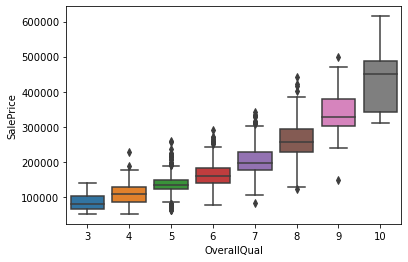

In [321]:
sns.boxplot(x='OverallQual',y='SalePrice',data=tdata)

<AxesSubplot:xlabel='OverallQual', ylabel='OverallCond'>

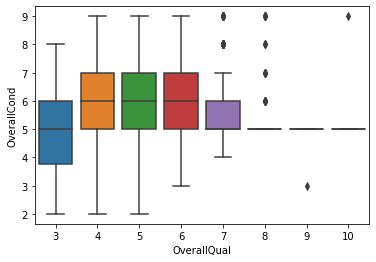

In [322]:
sns.boxplot(x='OverallQual',y='OverallCond',data=tdata)

## OverallCond- 
-said we should binarize but going to do that in new col bc i actually like this as is now ...
-do we think this should be ordinal or nominal categorical? 

In [323]:
sum(tdata.OverallCond.isna())

0

In [324]:
tdata.OverallCond.value_counts()

5    1193
6     440
7     334
8     132
4      59
9      34
3      24
2       3
Name: OverallCond, dtype: int64

(array([   3.,   24.,   59.,    0., 1193.,  440.,    0.,  334.,  132.,
          34.]),
 array([2. , 2.7, 3.4, 4.1, 4.8, 5.5, 6.2, 6.9, 7.6, 8.3, 9. ]),
 <BarContainer object of 10 artists>)

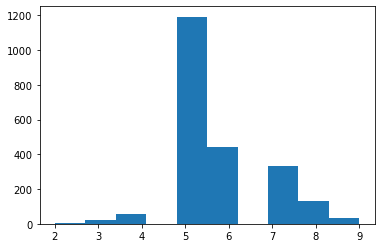

In [325]:
plt.hist(tdata.OverallCond)

<AxesSubplot:xlabel='OverallCond', ylabel='SalePrice'>

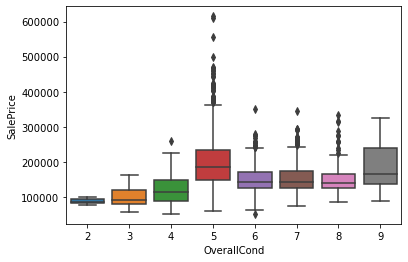

In [326]:
sns.boxplot(x='OverallCond',y='SalePrice',data=tdata)

## OverallCondBinary
-below average y or no 

In [327]:
tdata['OverallCondBinary']=(tdata['OverallCond']<5).astype(int)
tdata=tdata.drop('OverallCond',1)

## GeoRefNo

In [328]:
sum(tdata.GeoRefNo.isna())

14

In [329]:
#nothing I can do about these nas rn- will become an issue for computing distance
#to college. at that time we can impute the avrg distance or since small # instances do manually if
#they have an address

#themissing21 = indices of these rows  in case want to drop 

# Distance to campus column

In [330]:
def getlatlong(address):
    try:
        address=address+', Ames, Iowa'
    
        location = locator.geocode(address)
        lat=location[1][0]
        long=location[1][1]
        return [lat,long]
    except:
        return ''
    

In [331]:
def distancetoUoI(latlong):
    UofIowa=[42.026640, -93.646456]
    try:
        return great_circle(latlong, UofIowa).km
    except:
        return ''

In [332]:
locator = Nominatim(user_agent="myGeocoder")
tdata['Lat_Long']=tdata.Prop_Addr.apply((lambda address: getlatlong(address)))

In [333]:
tdata['Dist_From_UoI']=tdata.Lat_Long.apply(lambda latlong:  distancetoUoI(latlong))

In [334]:
#tdata.Lat_Long

## Prop_Addr

In [335]:
sum((tdata.Prop_Addr.isna()))#&(tdata.GeoRefNo.isna()))
#same 21 w no address- nothing can do bout that 


14

## SchD_S
-binary- 1 means school dist 5 else dist 1

In [336]:
sum((tdata.SchD_S.isna()) &(tdata.GeoRefNo.isna()))
#same 21 w no address- impute mode

14

In [337]:
tdata.SchD_S.value_counts()

1.0    1922
5.0     283
Name: SchD_S, dtype: int64

In [338]:
tdata.SchD_S[tdata.SchD_S.isna()]=1.0

<ipython-input-338-6fb3b8e8450f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata.SchD_S[tdata.SchD_S.isna()]=1.0


In [339]:
tdata['SchD_S'] = np.where(tdata['SchD_S']== 5.0, 1, 0)

In [340]:
sum(tdata['SchD_S']==1)

283

## TxD_S 
-this is perfectly corr w school dist- drop 

In [341]:
sum((tdata.TxD_S.isna()))

14

In [342]:
tdata.TxD_S.value_counts()

1.0     1922
45.0     283
Name: TxD_S, dtype: int64

In [343]:
tdata.TxD_S[tdata.TxD_S.isna()]=1.0
tdata['TxD_S'] = np.where(tdata['TxD_S']== 45.0, 1, 0)

<ipython-input-343-c4b4d3829437>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata.TxD_S[tdata.TxD_S.isna()]=1.0


In [344]:
tdata=tdata.drop(columns='TxD_S')

## LndAc_S
-thinking bout filling in the nas and zeros with the avrg land ac size for the given lot area cause theyre roughly corr and rando avrg might not make sense
-hypothesize we will see some correlations in cols 

In [345]:
sum((tdata.LndAc_S.isna()) )

14

In [346]:
themissing21=tdata.index[(tdata.LndAc_S.isna())].tolist()

In [347]:
tdata[tdata.LndAc_S==0]

,PID,GrLivArea,SalePrice,MSSubClass,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,OthAc_S,Remodeled,RemodelYrsAftBuilt,UnpavedDrive,WoodDeckBinary,HasPorch,FenceBinary,OverallCondBinary,Lat_Long,Dist_From_UoI


In [348]:
tdata.LndAc_S.value_counts()

44000.0    13
56200.0    11
43900.0    10
42800.0    10
40200.0    10
           ..
81500.0     1
29300.0     1
80000.0     1
85000.0     1
84300.0     1
Name: LndAc_S, Length: 700, dtype: int64

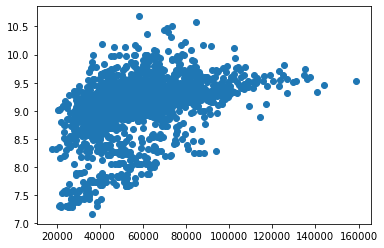

In [349]:
plt.scatter(tdata['LndAc_S'], np.log(tdata['LotArea']))
#vis corr w lot area 

In [350]:
# not needed, no rows == 0 anymore

#tdata.LndAc_S[tdata.LndAc_S==0]=tdata.LotArea[tdata.LotArea==]
#LA=int(tdata[tdata.LndAc_S==0].LotArea)
#tdata.LndAc_S[tdata.LndAc_S==0]=round(tdata[(tdata.LotArea>LA*.9) & (tdata.LotArea<LA*1.1)].LndAc_S.mean()
#)

In [351]:
list((tdata.LotArea[((tdata.LndAc_S.isna()))]).keys())

[79, 109, 404, 683, 895, 1088, 1204, 1346, 1516, 2011, 2139, 2168, 2228, 2531]

In [352]:
imputedvals=[]
keysofnas=list((tdata.LotArea[((tdata.LndAc_S.isna()))]).keys())
for i in range(sum(tdata.LndAc_S.isna())):
    LA=tdata.loc[keysofnas[i],'LotArea']
    imputedvals.append(round(tdata[(tdata.LotArea>LA*.9) & (tdata.LotArea<LA*1.1)].LndAc_S.mean())
    )  

In [353]:
tdata.LndAc_S[((tdata.LndAc_S.isna()))]=imputedvals

<ipython-input-353-90775d9f79f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata.LndAc_S[((tdata.LndAc_S.isna()))]=imputedvals


In [354]:
tdata.loc[109,'LndAc_S']

54980.0

## OthAc_S
-we need to drop either this or lndac_s asap due to corr- didnt even need a test just visually 


In [355]:
sum((tdata.OthAc_S.isna()) )

14

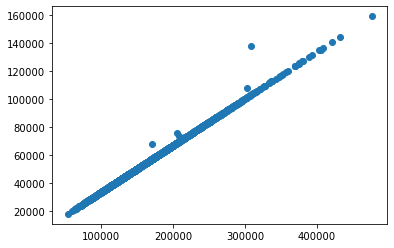

In [356]:
plt.scatter(tdata['OthAc_S'], (tdata['LndAc_S']))

In [357]:
tdata=tdata.drop(columns='OthAc_S')

In [358]:
#Dropping columns that weren't earlier because they were needed for more code later. Done with them now.
# tdata=tdata.drop(columns='GarageType') # No need todrop this, it was only for being dummied. 
# tdata=tdata.drop(columns='GarageFinish') # No need to drop this, it was only dropped for dummying.


# ============
# JUDE'S CODE
# ============

## Columns

#### GrLivArea - keep as is
#### MSSubClass - combine into 1stry, 1plus_stry, multi then dummify
#### LotFrontage - drop
#### LotArea - keep as is
#### LotShape - binarize
#### LandContour - binarize into "level" and "other"
#### LotConfig - combine into "culdesac",  "inside", "corner"
#### Neighborhood - keep as is
#### Condition1 - cat into "Normal", "Feedr", "Artery", "Railroad", "Positive" then dummify
#### BldgType - combine 2fam conv and duplex then dummify

### MSSubClass

In [359]:
# Initial State

tdata['MSSubClass'].value_counts()

20     838
60     461
50     237
120    156
160    113
70     107
80     105
30     104
85      43
75      17
45      17
180     14
40       6
150      1
Name: MSSubClass, dtype: int64

In [360]:
# Transform Data

tdata['MSSubClass'].replace([20, 30, 40, 80, 85, 120], 'one_story', inplace=True)
tdata['MSSubClass'].replace([45, 50, 60, 70, 75, 150, 160, 180], '>1-story', inplace=True)
tdata['MSSubClass'].replace([90, 190], 'multi_fam', inplace=True)

In [361]:
# Check Transformation

tdata['MSSubClass'].value_counts()

one_story    1252
>1-story      967
Name: MSSubClass, dtype: int64

In [362]:
tdata['MSSubClass'] = tdata['MSSubClass'].astype('category')
tdata['MSSubClass'].value_counts()

one_story    1252
>1-story      967
Name: MSSubClass, dtype: int64

### LotFrontage (DROPPED)

### LotShape

In [363]:
# Initial State

tdata['LotShape'].value_counts()

Reg    1396
IR1     755
IR2      58
IR3      10
Name: LotShape, dtype: int64

In [364]:
# Transform Data

tdata['LotShape'].replace(['IR1', 'IR2', 'IR3'], 'IR', inplace=True)

In [365]:
# Check Transformation

tdata['LotShape'].value_counts()

Reg    1396
IR      823
Name: LotShape, dtype: int64

In [366]:
# Dummify, drop 'Reg'

LotShape_dums = pd.get_dummies(tdata['LotShape'], prefix='LotShape', prefix_sep='_').drop('LotShape_Reg', 1)
tdata = pd.concat([tdata.drop('LotShape', 1), LotShape_dums], axis=1)

In [367]:
# Check new column
tdata.iloc[:,-1:].value_counts()

LotShape_IR
0              1396
1               823
dtype: int64

### LandContour

In [368]:
# Initial State

tdata['LandContour'].value_counts()

Lvl    2023
HLS      83
Bnk      77
Low      36
Name: LandContour, dtype: int64

In [369]:
# Transform Data

tdata['LandContour'].replace(['HLS', 'Bnk', 'Low'], 'slope', inplace=True)

In [370]:
# Check Transformation

tdata['LandContour'].value_counts()

Lvl      2023
slope     196
Name: LandContour, dtype: int64

In [371]:
# Dummify, drop 'Lvl'

LandContour_dums = pd.get_dummies(tdata['LandContour'], prefix='LandContour', prefix_sep='_').drop("LandContour_Lvl", 1)
tdata = pd.concat([tdata.drop('LandContour', 1), LandContour_dums], axis=1)

In [372]:
tdata.rename(columns={'LandContour_slope':'SlopedLot'}, inplace=True)
tdata.iloc[:,-1:].value_counts()

SlopedLot
0            2023
1             196
dtype: int64

### LotConfig

In [373]:
# Initial State

tdata['LotConfig'].value_counts()

Inside     1623
Corner      374
CulDSac     143
FR2          68
FR3          11
Name: LotConfig, dtype: int64

In [374]:
# Transform Data

tdata['LotConfig'].replace(['FR2', 'FR3'], 'Corner', inplace=True)

In [375]:
# Check Transformation

tdata['LotConfig'].value_counts()

Inside     1623
Corner      453
CulDSac     143
Name: LotConfig, dtype: int64

In [376]:
tdata['LotConfig'] = tdata['LotConfig'].astype('category')
print(tdata['LotConfig'].dtypes)

category


### Condition1

In [377]:
# Initial State

tdata['Condition1'].value_counts()

Norm      1935
Feedr      109
Artery      62
PosN        34
RRAn        32
RRAe        19
PosA        18
RRNn         6
RRNe         4
Name: Condition1, dtype: int64

In [378]:
# Transform Data

tdata['Condition1'].replace(['RRAn', 'RRAe', 'RRNe', 'RRNn'], 'RailRd', inplace=True)
tdata['Condition1'].replace(['PosN', 'PosA'], 'Pos', inplace=True)

In [379]:
# Check Transformation

tdata['Condition1'].value_counts()

Norm      1935
Feedr      109
Artery      62
RailRd      61
Pos         52
Name: Condition1, dtype: int64

In [380]:
tdata['Condition1'] = tdata['Condition1'].astype('category')
print(tdata['Condition1'].dtypes)

category


### BldgType

In [381]:
# Initial State

tdata['BldgType'].value_counts()

1Fam      1938
TwnhsE     189
Twnhs       90
2fmCon       2
Name: BldgType, dtype: int64

In [382]:
# Transform Data

tdata['BldgType'].replace(['Duplex', '2fmCon'], '2Fam', inplace=True)

In [383]:
# Check Transformation

tdata['BldgType'].value_counts()

1Fam      1938
TwnhsE     189
Twnhs       90
2Fam         2
Name: BldgType, dtype: int64

In [384]:
tdata['BldgType'] = tdata['BldgType'].astype('category')
print(tdata['BldgType'].dtypes)

category


# ============================
# FINISHED COLUMN PROCESSING
# ============================
The rest of the code below is to check out the columns we are left with now and to save a new dataset.

In [385]:
tdata

,PID,GrLivArea,SalePrice,MSSubClass,LotArea,LotConfig,Neighborhood,Condition1,BldgType,OverallQual,...,RemodelYrsAftBuilt,UnpavedDrive,WoodDeckBinary,HasPorch,FenceBinary,OverallCondBinary,Lat_Long,Dist_From_UoI,LotShape_IR,SlopedLot
0,909176150,856,126000,one_story,7890,Corner,SWISU,Norm,1Fam,6,...,11,0,False,1,0,0,"[42.01856448979592, -93.65161918367347]",0.994098,0,0
1,905476230,1049,139500,one_story,4235,Inside,Edwards,Norm,TwnhsE,5,...,0,0,False,1,0,0,"[42.024855315930424, -93.66367099341755]",1.43575,0,0
3,535377150,1039,114000,>1-story,8146,Corner,OldTown,Norm,1Fam,4,...,103,1,False,1,0,0,"[42.03739146938776, -93.61220695918368]",3.07097,0,0
4,534177230,1665,227000,>1-story,8400,Inside,NWAmes,Norm,1Fam,8,...,0,0,False,1,0,0,"[42.04455376067282, -93.63181831620726]",2.33006,0,0
5,908128060,1922,198500,one_story,7301,Corner,Edwards,Norm,1Fam,7,...,0,0,False,1,0,0,"[42.01900877172312, -93.67298690279817]",2.35011,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2574,908128100,1724,196500,>1-story,7162,Inside,Edwards,Norm,1Fam,7,...,1,0,True,1,0,0,"[42.019007, -93.67274607047453]",2.33164,0,0
2575,903205040,952,121000,one_story,8854,Inside,BrkSide,Norm,1Fam,6,...,34,1,False,1,0,0,"[42.032101777475496, -93.6263728406611]",1.76647,0,0
2576,905402060,1733,139600,one_story,13680,CulDSac,Edwards,Norm,1Fam,3,...,0,0,False,0,0,0,"[42.027669288907106, -93.6661381147073]",1.62974,1,0
2578,907192040,1842,217500,>1-story,8826,Inside,CollgCr,Norm,1Fam,7,...,0,0,True,1,0,0,"[42.016802051693205, -93.6897483798832]",3.73977,0,0


In [386]:
#The below shows columns that have the most 0's, or highest sparsity of data.
np.sum(~tdata.astype(bool), axis=0).sort_values(ascending=False)[0:60]


OverallCondBinary     2133
NoCentralAir          2126
BsmtHalfBath          2073
NonStdElectrical      2058
UnpavedDrive          2038
SlopedLot             2023
SchD_S                1936
FenceBinary           1738
BsmtExposure          1723
BsmtFinGdLvng         1554
LotShape_IR           1396
HalfBath              1365
MasVnrArea            1340
BsmtFullBath          1271
2ndFlrSF              1247
Remodeled             1202
RemodelYrsAftBuilt    1201
WoodDeckBinary        1124
Fireplaces            1018
HasPorch               648
BsmtUnfSF              159
GarageArea              76
GarageCars              76
Lat_Long                52
Dist_From_UoI           52
TotalBsmtSF             40
BedroomAbvGr             5
FullBath                 4
YearBuilt                0
MasVnrType               0
Exterior1st              0
GrLivArea                0
SalePrice                0
RoofStyle                0
MSSubClass               0
Condition1               0
LotArea                  0
O

In [387]:
#Need to come up with a reasonable order for columns. And figure out which are telling ust he same things.
tdata.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'LotArea', 'LotConfig',
       'Neighborhood', 'Condition1', 'BldgType', 'OverallQual', 'YearBuilt',
       'RoofStyle', 'Exterior1st', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinGdLvng',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'NoCentralAir',
       'NonStdElectrical', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'MoSold', 'GeoRefNo',
       'Prop_Addr', 'SchD_S', 'LndAc_S', 'Remodeled', 'RemodelYrsAftBuilt',
       'UnpavedDrive', 'WoodDeckBinary', 'HasPorch', 'FenceBinary',
       'OverallCondBinary', 'Lat_Long', 'Dist_From_UoI', 'LotShape_IR',
       'SlopedLot'],
      dtype='object')

Proposed Ordering:

**First the dependent variable**
'SalePrice'
**Next all the things not machine-learning related, to make them easy to identify and drop**
'PID'
'MoSold'
'GeoRefNo'
'Prop_Addr'
**Everything to do with the size of the house**
'GrLivArea'
'1stFlrSF'
'2ndFlrSF'
'TotRmsAbvGrd'
'BedroomAbvGr'
'FullBath'
'HalfBath'
'MSSubClass_one_plus_stry'
'MSSubClass_multi_stry'
'BldgType_Twnhs'
'BldgType_TwnhsE'
'BldgType_2Fam'
**Everything to do with the lot**
'LotArea'
'LndAc_S'
'LotShape_IR'
'LandContour_slope'
'LotConfig_Corner'
'LotConfig_CulDSac'
'Condition1_Artery'
'Condition1_Feedr'
'Condition1_Pos'
'Condition1_RailRd'
**Everything to do with the building materials of the house**
'NonStdElectrical'
'MasVnrArea'
'MasVnrType_BrkFace'
'MasVnrType_StoneBrkcom'
'RoofStyle_Hip'
'RoofStyle_Other'
'Exterior1st_AsbShng'
'Exterior1st_BrkFace'
'Exterior1st_HdbdOther'
'Exterior1st_MetalSd'
'Exterior1st_Stc_CemBd_WdSdSh'
'Foundation_BrkTil'
'Foundation_PConc'
'Foundation_Slab'
'Foundation_Stone'
'Foundation_Wood'
**Everything to do with the quality of the house**
'YearBuilt'
'OverallQual'
'OverallCondBinary'
'ExterQual'
'HeatingQC_Gd'
'HeatingQC_TA'
'HeatingQC_Fa'
'KitchenQual_Ex'
'KitchenQual_Gd'
'KitchenQual_Fa'
'Remodeled'
'RemodelYrsAftBuilt'
'Functional_Min'
'Functional_Maj'
'FireplaceQu'
**Everything to do with the Basement**
'BsmtQual_None'
'BsmtCond_None'
'TotalBsmtSF'
'BsmtUnfSF'
'BsmtFinGdLvng'
'BsmtHalfBath'
'BsmtFullBath'
'BsmtExposure'
'BsmtQual_Ex'
'BsmtQual_Gd'
'BsmtQual_Fa'
'BsmtCond_Gd'
'BsmtCond_Fa'
**Everything to do with Garages**
'GarageType_Detchd'
'GarageType_None'
'GarageFinish_None'
'GarageArea'
'GarageCars'
'GarageFinish_Fin'
'GarageFinish_RFn'
**Information on 'amenities'**
'Neighborhood'
'UnpavedDrive'
'WoodDeckBinary'
'HasPorch'
'FenceBinary'
'Fireplaces'
'NoCentralAir'
'SchD_S'


NOTE: This will have to be edited and tweaked as we go on.

In [388]:
ordered_col_list_2 = ['SalePrice', #dependent Variable
                   'PID', 'Prop_Addr', 'GeoRefNo', 'MoSold','Lat_Long', #Not ML-related
                   'Dist_From_UoI', 'GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'BedroomAbvGr', 
                    'FullBath', 'HalfBath', 'MSSubClass', 
                    'BldgType', #Size of the house 
                    'LotArea', 'LndAc_S', 'LotShape_IR', 'SlopedLot', 'LotConfig', 'Condition1', #Lot columns
                    'NonStdElectrical', 'MasVnrArea', 'MasVnrType', 
                    'RoofStyle', 'Exterior1st', 
                    'Foundation', # Building Materials
                   'YearBuilt', 'OverallQual', 'OverallCondBinary', 'ExterQual', 'HeatingQC', 'KitchenQual', 'Remodeled', 'RemodelYrsAftBuilt', 'Functional', 'FireplaceQu', #Quality of house
                   'BsmtQual', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinGdLvng', 
                    'BsmtHalfBath', 'BsmtFullBath', 'BsmtExposure', 'BsmtQual', 'BsmtCond', #Basement columns
                   'GarageType', 'GarageFinish', 'GarageArea', 
                    'GarageCars', # Garage Columns
                    'UnpavedDrive', 'WoodDeckBinary', 'HasPorch', 'FenceBinary', 
                    'Fireplaces', 'NoCentralAir', 'SchD_S'] # Amenity Columns






In [389]:
tdata = tdata.reindex(columns=ordered_col_list_2)

In [390]:
#tdata.to_csv(r'initial_condensed_data.csv', index=False)

In [391]:
tdata

,SalePrice,PID,Prop_Addr,GeoRefNo,MoSold,Lat_Long,Dist_From_UoI,GrLivArea,1stFlrSF,2ndFlrSF,...,GarageFinish,GarageArea,GarageCars,UnpavedDrive,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S
0,126000,909176150,436 HAYWARD AVE,909176150.0,3,"[42.01856448979592, -93.65161918367347]",0.994098,856,856,0,...,Unf,399.0,2.0,0,False,1,0,1,0,0
1,139500,905476230,3416 WEST ST,905476230.0,2,"[42.024855315930424, -93.66367099341755]",1.43575,1049,1049,0,...,Fin,266.0,1.0,0,False,1,0,0,0,0
3,114000,535377150,1524 DOUGLAS AVE,535377150.0,5,"[42.03739146938776, -93.61220695918368]",3.07097,1039,717,322,...,Unf,281.0,1.0,1,False,1,0,0,0,0
4,227000,534177230,2304 FILLMORE AVE,534177230.0,11,"[42.04455376067282, -93.63181831620726]",2.33006,1665,810,855,...,Fin,528.0,2.0,0,False,1,0,0,0,0
5,198500,908128060,4003 MARIGOLD DR,908128060.0,7,"[42.01900877172312, -93.67298690279817]",2.35011,1922,495,1427,...,RFn,672.0,2.0,0,False,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2574,196500,908128100,4019 MARIGOLD DR,908128100.0,5,"[42.019007, -93.67274607047453]",2.33164,1724,806,918,...,Fin,616.0,2.0,0,True,1,0,1,0,0
2575,121000,903205040,1021 RIDGEWOOD AVE,903205040.0,5,"[42.032101777475496, -93.6263728406611]",1.76647,952,952,0,...,Unf,192.0,1.0,1,False,1,0,1,1,0
2576,139600,905402060,3619 MARY CIR,905402060.0,6,"[42.027669288907106, -93.6661381147073]",1.62974,1733,1733,0,...,Unf,452.0,2.0,0,False,0,0,1,0,0
2578,217500,907192040,5319 CLEMENS BLVD,907192040.0,7,"[42.016802051693205, -93.6897483798832]",3.73977,1842,985,857,...,Fin,486.0,2.0,0,True,1,0,1,0,0


# Split Test Train

In [392]:
data_only_ml_cols=tdata.drop(['PID', 'Prop_Addr', 'GeoRefNo', 'MoSold'], axis=1)

In [393]:
 tdata_train, tdata_test = train_test_split(data_only_ml_cols, test_size=0.33, random_state=100)

In [394]:
tdata_train.shape

(1486, 54)

In [ ]:
tdata_test.shape

In [395]:
temp=tdata_train
temp1=tdata_test

## Adding in the Neighborhood Cluster Labels

In [396]:
NeighborhoodlabelsTRAIN=pd.read_csv('NeighborhoodlabelsTRAIN.csv', index_col=0)
NeighborhoodlabelsTEST=pd.read_csv('NeighborhoodlabelsTEST.csv', index_col=0)

In [397]:
NeighborhoodlabelsTRAIN

,Neighborhood Cluster Label_2,Neighborhood Cluster Label_3,Neighborhood Cluster Label_4,Neighborhood Cluster Label_5
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1481,0,0,0,0
1482,0,0,0,0
1483,1,0,0,0
1484,0,0,0,0


In [401]:
# dropping like 20 rows that dont have lats longs
#lndmrkrow=int(tdata_train.Neighborhood.index[tdata_train.Neighborhood=='Landmrk'][0])
#tdata_train=tdata_train.drop([lndmrkrow])
DroppedNoLat=((tdata_train.Lat_Long=='')==False)
tdata_train=tdata_train[DroppedNoLat]


In [402]:
tdata_train

,SalePrice,Lat_Long,Dist_From_UoI,GrLivArea,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,...,GarageFinish,GarageArea,GarageCars,UnpavedDrive,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S
2360,179200,"[42.036345280662346, -93.6878802695534]",3.58753,1294,1294,0,6,3,2,0,...,RFn,496.0,2.0,0,True,1,1,0,0,0
1975,115000,"[42.038378, -93.61261990196078]",3.08436,1540,1040,500,7,4,1,0,...,Unf,352.0,1.0,0,False,0,0,0,0,0
2238,110000,"[42.04854121553709, -93.6265682965729]",2.9374,892,892,0,5,3,1,0,...,RFn,264.0,1.0,0,False,0,1,0,0,0
464,131750,"[42.018681900000004, -93.6663829759606]",1.86884,960,960,0,4,2,1,0,...,Unf,392.0,1.0,0,True,1,0,0,0,0
220,190000,"[42.055141, -93.633802]",3.33701,1969,1161,808,8,3,2,1,...,RFn,534.0,2.0,0,False,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,195000,"[42.0624755, -93.6414793]",4.00587,1455,1455,0,6,2,2,0,...,Fin,644.0,3.0,0,True,1,0,1,0,1
2258,146500,"[42.02730468048847, -93.60702960866344]",3.25742,1521,780,741,8,4,1,0,...,Unf,640.0,3.0,0,False,1,1,0,0,0
99,211500,"[42.04299352441229, -93.64930425966442]",1.83358,1226,1226,0,4,1,1,0,...,Fin,484.0,2.0,0,True,1,0,2,0,0
2176,117000,"[42.021659183673464, -93.68313334693877]",3.07985,875,875,0,5,3,1,0,...,Unf,728.0,2.0,0,True,0,0,0,0,0


In [403]:
NeighborhoodlabelsTRAIN
#tdata_train

,Neighborhood Cluster Label_2,Neighborhood Cluster Label_3,Neighborhood Cluster Label_4,Neighborhood Cluster Label_5
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1481,0,0,0,0
1482,0,0,0,0
1483,1,0,0,0
1484,0,0,0,0


In [404]:
tdata_train.reset_index()

,index,SalePrice,Lat_Long,Dist_From_UoI,GrLivArea,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,BedroomAbvGr,FullBath,...,GarageFinish,GarageArea,GarageCars,UnpavedDrive,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S
0,2360,179200,"[42.036345280662346, -93.6878802695534]",3.58753,1294,1294,0,6,3,2,...,RFn,496.0,2.0,0,True,1,1,0,0,0
1,1975,115000,"[42.038378, -93.61261990196078]",3.08436,1540,1040,500,7,4,1,...,Unf,352.0,1.0,0,False,0,0,0,0,0
2,2238,110000,"[42.04854121553709, -93.6265682965729]",2.9374,892,892,0,5,3,1,...,RFn,264.0,1.0,0,False,0,1,0,0,0
3,464,131750,"[42.018681900000004, -93.6663829759606]",1.86884,960,960,0,4,2,1,...,Unf,392.0,1.0,0,True,1,0,0,0,0
4,220,190000,"[42.055141, -93.633802]",3.33701,1969,1161,808,8,3,2,...,RFn,534.0,2.0,0,False,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,447,195000,"[42.0624755, -93.6414793]",4.00587,1455,1455,0,6,2,2,...,Fin,644.0,3.0,0,True,1,0,1,0,1
1445,2258,146500,"[42.02730468048847, -93.60702960866344]",3.25742,1521,780,741,8,4,1,...,Unf,640.0,3.0,0,False,1,1,0,0,0
1446,99,211500,"[42.04299352441229, -93.64930425966442]",1.83358,1226,1226,0,4,1,1,...,Fin,484.0,2.0,0,True,1,0,2,0,0
1447,2176,117000,"[42.021659183673464, -93.68313334693877]",3.07985,875,875,0,5,3,1,...,Unf,728.0,2.0,0,True,0,0,0,0,0


In [405]:
tdata_train=tdata_train.reset_index()
tdata_test=tdata_test.reset_index()
tdata_train = tdata_train.drop(['index'], axis=1)
tdata_test = tdata_test.drop(['index'], axis=1)

In [406]:
NeighborhoodlabelsTRAIN=NeighborhoodlabelsTRAIN.reset_index()
NeighborhoodlabelsTEST=NeighborhoodlabelsTEST.reset_index()
NeighborhoodlabelsTEST = NeighborhoodlabelsTEST.drop(['index'], axis=1)
NeighborhoodlabelsTRAIN = NeighborhoodlabelsTRAIN.drop(['index'], axis=1)

In [407]:
NeighborhoodlabelsTRAIN

,Neighborhood Cluster Label_2,Neighborhood Cluster Label_3,Neighborhood Cluster Label_4,Neighborhood Cluster Label_5
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1444,0,0,0,0
1445,0,0,0,0
1446,1,0,0,0
1447,0,0,0,0


In [408]:
tdata_train=pd.concat([tdata_train, NeighborhoodlabelsTRAIN], axis=1)
tdata_test=pd.concat([tdata_test, NeighborhoodlabelsTEST], axis=1)
drop_list=['Remodeled','LndAc_S']
tdata_train = tdata_train.drop(drop_list, axis=1)
tdata_test = tdata_test.drop(drop_list, axis=1)

In [409]:
tdata_train

,SalePrice,Lat_Long,Dist_From_UoI,GrLivArea,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,...,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S,Neighborhood Cluster Label_2,Neighborhood Cluster Label_3,Neighborhood Cluster Label_4,Neighborhood Cluster Label_5
0,179200,"[42.036345280662346, -93.6878802695534]",3.58753,1294,1294,0,6,3,2,0,...,True,1,1,0,0,0,0,0,0,0
1,115000,"[42.038378, -93.61261990196078]",3.08436,1540,1040,500,7,4,1,0,...,False,0,0,0,0,0,0,0,0,0
2,110000,"[42.04854121553709, -93.6265682965729]",2.9374,892,892,0,5,3,1,0,...,False,0,1,0,0,0,0,0,0,0
3,131750,"[42.018681900000004, -93.6663829759606]",1.86884,960,960,0,4,2,1,0,...,True,1,0,0,0,0,0,0,0,0
4,190000,"[42.055141, -93.633802]",3.33701,1969,1161,808,8,3,2,1,...,False,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,195000,"[42.0624755, -93.6414793]",4.00587,1455,1455,0,6,2,2,0,...,True,1,0,1,0,1,0,0,0,0
1445,146500,"[42.02730468048847, -93.60702960866344]",3.25742,1521,780,741,8,4,1,0,...,False,1,1,0,0,0,0,0,0,0
1446,211500,"[42.04299352441229, -93.64930425966442]",1.83358,1226,1226,0,4,1,1,0,...,True,1,0,2,0,0,1,0,0,0
1447,117000,"[42.021659183673464, -93.68313334693877]",3.07985,875,875,0,5,3,1,0,...,True,0,0,0,0,0,0,0,0,0


In [410]:
#ensuring all boolean cols are evenly distributed

fullsetvalues=np.sum(~tdata.astype(bool), axis=0)
trainsetvalues=np.sum(~tdata_train.astype(bool), axis=0)


In [411]:
#none of the sparse bool cols have abnoraml dist btw test and train. 
#should have ~66% of bools cols weight in the train anything above 70 or below 60 is shown
#only problamtic cols are not bools and this just says 75% houses w no above ground bedrooms are in this set and same logic w fullbath
((trainsetvalues/fullsetvalues ).sort_values(ascending=False))[(((trainsetvalues/fullsetvalues ).sort_values(ascending=False))>.7) | (((trainsetvalues/fullsetvalues ).sort_values(ascending=False))<.6)]

FullBath         1.0
BedroomAbvGr     0.8
Dist_From_UoI    0.0
Lat_Long         0.0
dtype: float64

In [412]:
tdata_train.to_csv(r'RowFiltered_condensed_data_TRAIN.csv', index=False)

In [413]:
tdata_test.to_csv(r'RowFiltered_condensed_data_TEST.csv', index=False)

In [414]:
# Check that no NaN's are left over. 
print('Null values in train: ', np.sum(np.sum(tdata_train.isnull(),axis=1),axis=0))
print('Null values in test: ', np.sum(np.sum(tdata_test.isnull(),axis=1),axis=0))

Null values in train:  0
Null values in test:  0


In [415]:
tdata_train

,SalePrice,Lat_Long,Dist_From_UoI,GrLivArea,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,...,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S,Neighborhood Cluster Label_2,Neighborhood Cluster Label_3,Neighborhood Cluster Label_4,Neighborhood Cluster Label_5
0,179200,"[42.036345280662346, -93.6878802695534]",3.58753,1294,1294,0,6,3,2,0,...,True,1,1,0,0,0,0,0,0,0
1,115000,"[42.038378, -93.61261990196078]",3.08436,1540,1040,500,7,4,1,0,...,False,0,0,0,0,0,0,0,0,0
2,110000,"[42.04854121553709, -93.6265682965729]",2.9374,892,892,0,5,3,1,0,...,False,0,1,0,0,0,0,0,0,0
3,131750,"[42.018681900000004, -93.6663829759606]",1.86884,960,960,0,4,2,1,0,...,True,1,0,0,0,0,0,0,0,0
4,190000,"[42.055141, -93.633802]",3.33701,1969,1161,808,8,3,2,1,...,False,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,195000,"[42.0624755, -93.6414793]",4.00587,1455,1455,0,6,2,2,0,...,True,1,0,1,0,1,0,0,0,0
1445,146500,"[42.02730468048847, -93.60702960866344]",3.25742,1521,780,741,8,4,1,0,...,False,1,1,0,0,0,0,0,0,0
1446,211500,"[42.04299352441229, -93.64930425966442]",1.83358,1226,1226,0,4,1,1,0,...,True,1,0,2,0,0,1,0,0,0
1447,117000,"[42.021659183673464, -93.68313334693877]",3.07985,875,875,0,5,3,1,0,...,True,0,0,0,0,0,0,0,0,0
